In [4]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
!pip install openpyxl

In [6]:
# read excel file using pandas
df = pd.read_excel('For Graph preparation.xlsx')
# get all unique values of 'NameOfMeasurement' column
measurements = df['NameOfMeasurement'].unique()
# remove nans from measurements
measurements = measurements[~pd.isnull(measurements)]
# iterate over measurements
ctrl = []
ctrl_times = []

Isl1CKO = []
Isl1CKO_times = []

for measurement in measurements:
    # get df for current measurement
    df_measurement = df[df['NameOfMeasurement'] == measurement]
    # get Time(sec) column
    time = df_measurement['Time(sec)'].values
    path = df_measurement['CoordinateOfTip'].values
    new_path = []
    for x in path:
        # convert string to list of floats
        x = x.split('[')[1].split(']')[0].split(' ')
        coord = []
        for i in x:
            try:
                coord.append(float(i))
            except:
                continue
        new_path.append(coord)
    new_path = np.array(new_path)
    # if column Genotype is control, save to ctrl
    if df_measurement['Genotype'].values[0] == 'Control':
        ctrl.append(new_path)
        ctrl_times.append(np.array(time))
    # if column Genotype is Isl1CKO, save to Isl1CKO
    elif df_measurement['Genotype'].values[0] == 'Isl1CKO':
        Isl1CKO.append(new_path)
        Isl1CKO_times.append(np.array(time))
# print(Isl1CKO_times[5])

ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.

In [294]:
# make a function that would normalize rotation between axons
def normalize_rotation(array):
    # normalize each subarray to start at 0,0
    array = [a - a[0] for a in array]
    # for each subarray, find the angle between the first and last point
    rotated_array = []
    for i, a in enumerate(array):
        # if any element of a is negative, flip the vector
        # remove the negative sign in the y axis
        a[:,0] = np.abs(a[:,0])
        x = [0,1]
        y = [np.mean(a[:,0]), np.mean(a[:,1])]
        y = y / np.linalg.norm(y)
        theta = np.arccos(x @ y)
        angle = np.degrees(theta)
        # construct a rotation matrix to rotate the subarray by that angle
        c, s = np.cos(theta), np.sin(theta)
        R = np.array(((c, -s), (s, c)))
        # rotate the subarray
        a = R @ a.T
        rotated_array.append(a.T)
    return rotated_array

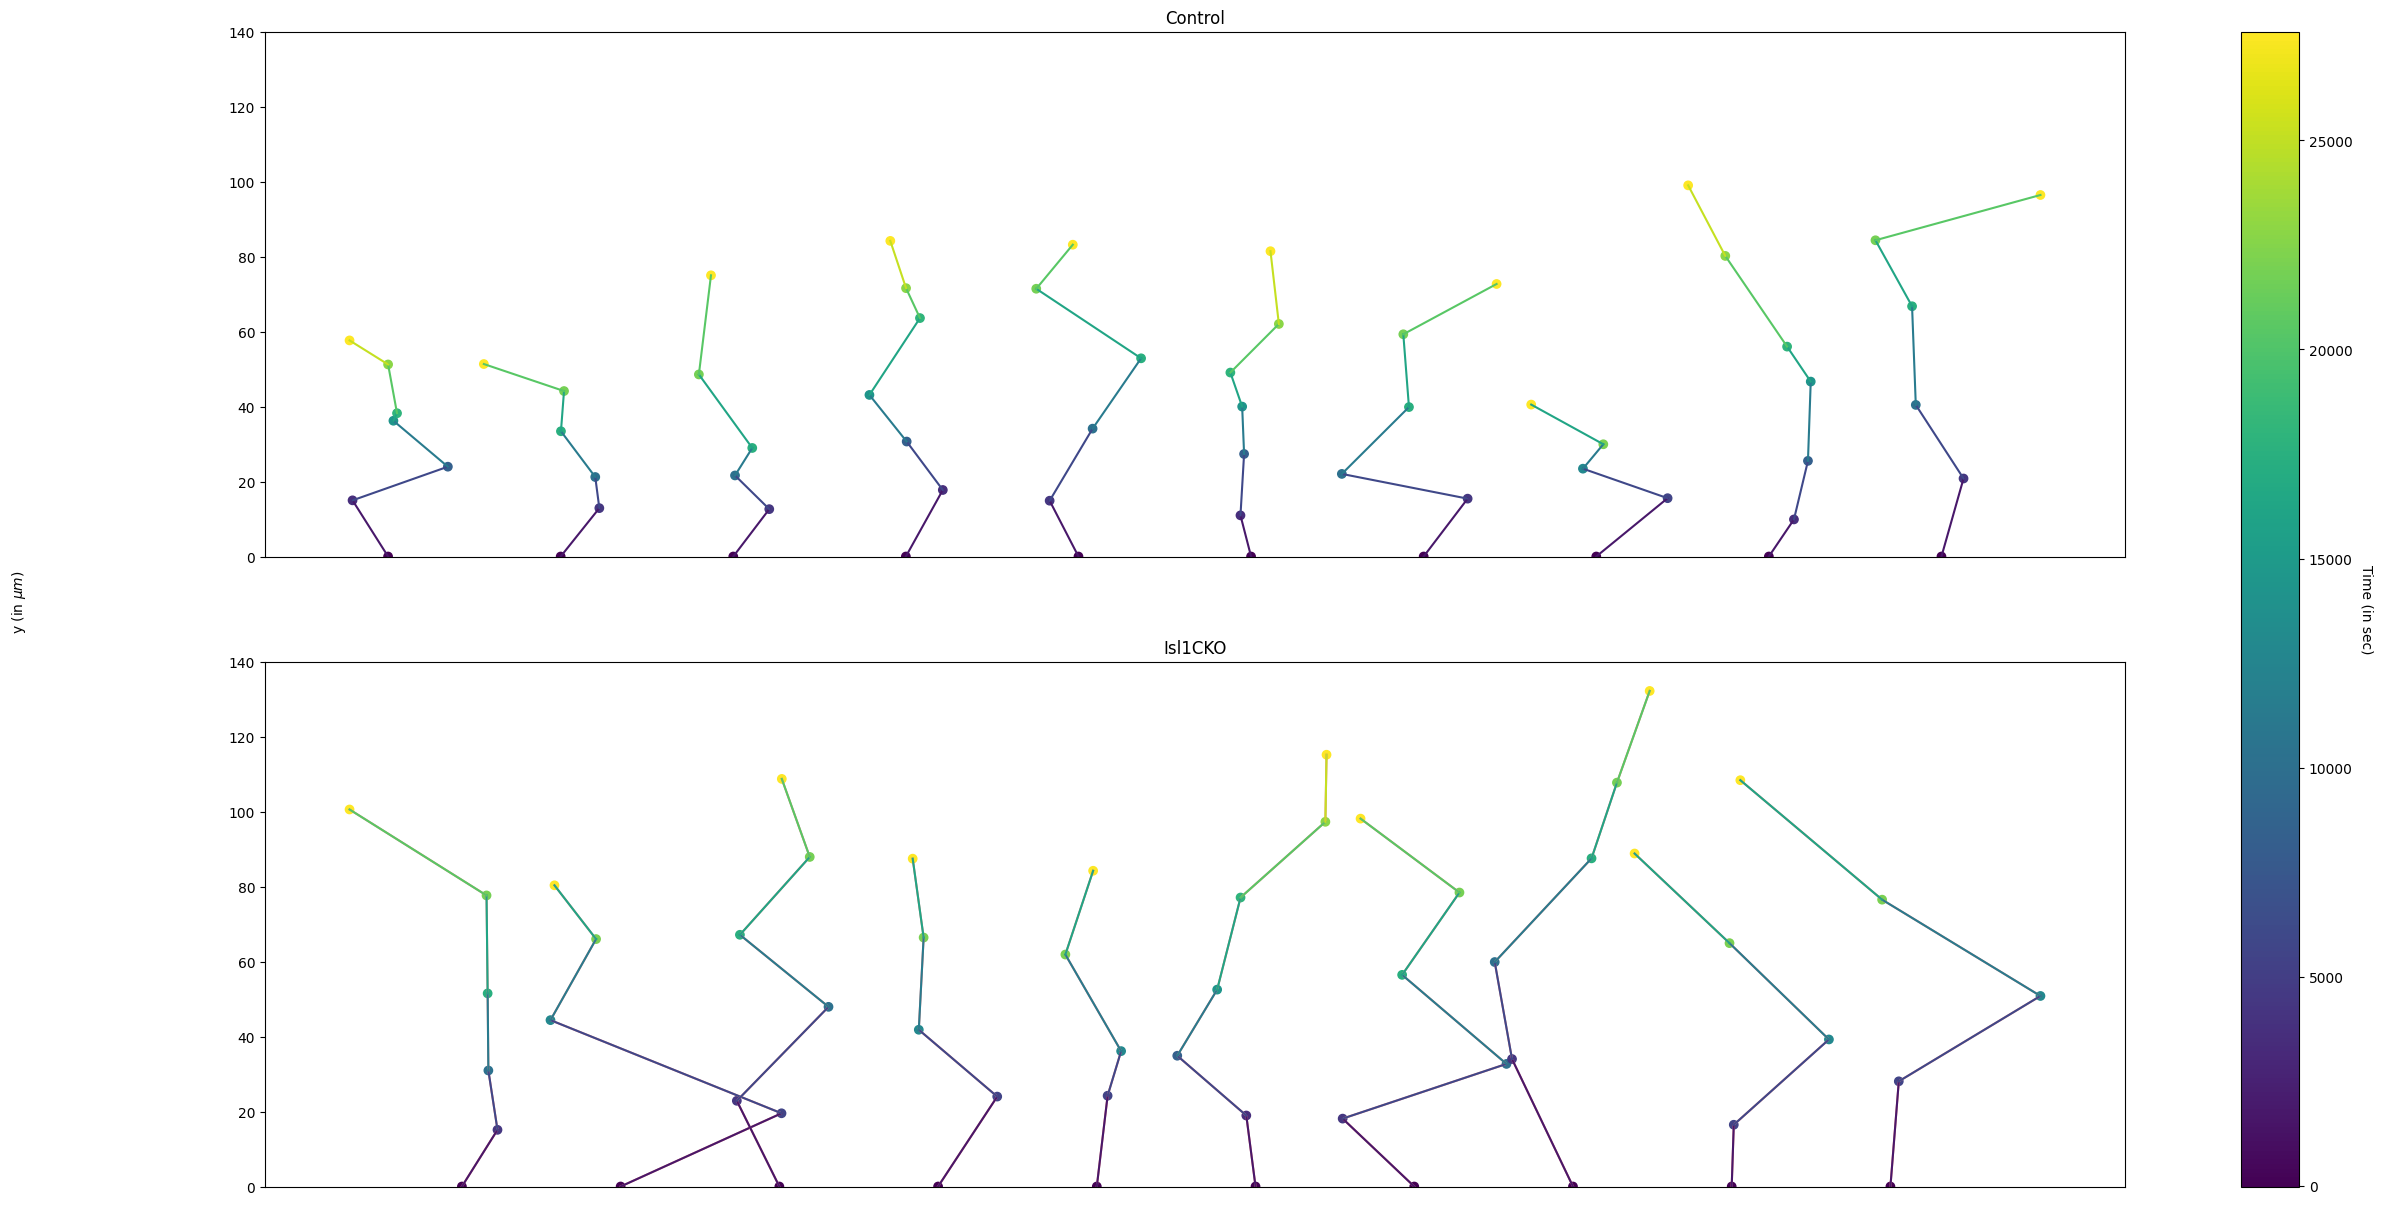

In [307]:
rotated_ctrl = normalize_rotation(ctrl)
rotated_lsl1CKO = normalize_rotation(Isl1CKO)
# create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10))
# find max value in times  and set colorbar
max_time = max([max(i) for i in ctrl_times + Isl1CKO_times])
# get all unique Time(sec) values from df
times = df['Time(sec)'].unique()
# remove nans from times
times = times[~pd.isnull(times)]
# interpolate times to get 100 values
times = np.interp(np.linspace(0, len(times), 1000), np.arange(len(times)), times)
# create a colorbar
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=[ax1, ax2], values=times)
# # create a colorbar using the max time and 0 as limits and add max time as label
cbar.set_label('Time (in sec)', rotation=270, labelpad=15)
# plot all arrays in a loop
for i in range(len(rotated_ctrl)):
    # add shift in x axis to make sure all plots are visible
    # ax1.plot(rotated_ctrl[i][:,0] + i * 10, rotated_ctrl[i][:,1], color='lightseagreen')
    # plot times as dots color them according to time
    ax1.scatter(rotated_ctrl[i][:,0] + i * 10, rotated_ctrl[i][:,1], c=ctrl_times[i], cmap='viridis')
    # plot also each part of path with different color
    for j, (start, stop) in enumerate(zip(rotated_ctrl[i][:-1], rotated_ctrl[i][1:])):
        x, y = zip(start, stop)
        # comvert tuple to list
        x = list(x)
        y = list(y)
        # add value of i to x to make sure all plots are visible
        x = [i * 10 + j for j in x]
        color = plt.cm.viridis((ctrl_times[i][j] + ctrl_times[i][j+1])/ (2*max_time))
        ax1.plot(x, y, color=color)
    
    # remove x axis ticks
    ax1.set_xticks([])
    # set y limits to 125
    ax1.set_ylim(0, 140)
    # set subplots label
    ax1.set_title('Control')

for i in range(len(rotated_lsl1CKO)):
    ax2.plot(rotated_lsl1CKO[i][:,0] + i * 10, rotated_lsl1CKO[i][:,1], color='lightcoral')
    ax2.scatter(rotated_lsl1CKO[i][:,0] + i * 10, rotated_lsl1CKO[i][:,1],c=Isl1CKO_times[i], cmap='viridis')

    for j, (start, stop) in enumerate(zip(rotated_lsl1CKO[i][:-1], rotated_lsl1CKO[i][1:])):
        x, y = zip(start, stop)
        # comvert tuple to list
        x = list(x)
        y = list(y)
        # add value of i to x to make sure all plots are visible
        x = [i * 10 + j for j in x]
        # compute color as a color between Isl1CKO_times[i][j] and Isl1CKO_times[i][j+1] normalized by max_time
        color = plt.cm.viridis((Isl1CKO_times[i][j] + Isl1CKO_times[i][j+1])/ (2*max_time))
        ax2.plot(x, y, color=color)

    # remove x axis ticks
    ax2.set_xticks([])
    # set y limits to 125
    ax2.set_ylim(0, 140)
    # set subplots label
    ax2.set_title('Isl1CKO')
# set figure y axis label
fig.text(0.04, 0.5, 'y (in $\mu m$)', va='center', rotation='vertical')
plt.show()